## Importing libraries

In [1]:
# Importing libraries
import pandas as pd
import numpy as np
from numpy.random import seed

seed(1)

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Dense, Dropout, Flatten, Conv2D,
                                     SeparableConv2D, ReLU, MaxPooling2D, Add, Input,
                                     BatchNormalization, MaxPool2D, GlobalAvgPool2D,
                                     RandomFlip, RandomRotation, RandomZoom)
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications.xception import Xception, decode_predictions, preprocess_input
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from numpy import expand_dims


from PIL import Image
import pickle

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import seaborn as sns
import requests
import datetime
import os

In [2]:
# printing GPU info to make sure the GPU is being utilized
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Nov 22 18:16:03 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# printing available RAM to make sure it's enough
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


## Reading in the data

In [4]:
# loading in Google Drive to retrieve the dataset(s)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# creating a path variable for the data subset we'll be modeling on
img_path = "/content/drive/My Drive/Capstone/food-11/images/dinner"
img_size = 299
img_size_tup = (299, 299)

# loading the images from the path into a train_data variable while resizing the images and splitting the data
# color mode will be 'rgb' which is 3 colors
# labels are 'categorical' since there are more than 2 categories
train_data = tf.keras.preprocessing.image_dataset_from_directory(
          img_path, 
          labels='inferred',
          label_mode='categorical',
          color_mode='rgb',
          batch_size=32,
          image_size=img_size_tup,
          shuffle=True,
          seed=13,
          validation_split=0.2,
          subset='training',
          # interpolation='bilinear',
          follow_links=True,
          # crop_to_aspect_ratio=True
)

Found 22019 files belonging to 22 classes.
Using 17616 files for training.


In [6]:
# loading the images for validation from the above split into a test_data variable while resizing same as above 

# directory_imgs = "/content/drive/My Drive/Capstone/food-11/validation"

test_data = tf.keras.preprocessing.image_dataset_from_directory(
          img_path,
          labels='inferred',
          label_mode='categorical',
          color_mode='rgb',
          batch_size=32,
          image_size=img_size_tup,
          shuffle=True,
          seed=13,
          validation_split=0.2,
          subset='validation',
          # interpolation='bilinear',
          follow_links=True,
          # crop_to_aspect_ratio=True
)

Found 22019 files belonging to 22 classes.
Using 4403 files for validation.


In [7]:
# looking at our train_data variable to see shape and type
train_data

<BatchDataset shapes: ((None, 299, 299, 3), (None, 22)), types: (tf.float32, tf.float32)>

In [8]:
class_names = test_data.class_names

n_classes = len(train_data.class_names)
n_classes, class_names

(22,
 ['baby_back_ribs',
  'bibimbap',
  'chicken_curry',
  'dumplings',
  'filet_mignon',
  'foie_gras',
  'fried_rice',
  'grilled_salmon',
  'lasagna',
  'lobster_bisque',
  'pad_thai',
  'paella',
  'peking_duck',
  'pizza',
  'pork_chop',
  'prime_rib',
  'ravioli',
  'risotto',
  'spaghetti_bolognese',
  'spaghetti_carbonara',
  'steak',
  'sushi'])

# EDA & Preprocessing the Data

In [9]:
# splitting our images and labels into X_train and y_train
# converting them to numpy arrays in order to be able to resize them
for images, labels in train_data.take(1):  # only take first element of dataset
    X_train = images.numpy()
    y_train = labels.numpy()

In [10]:
# doing the same as above for our test_data
for images, labels in test_data.take(1):  # only take first element of dataset
    X_test = images.numpy()
    y_test = labels.numpy()

In [11]:
X_train[0][0][0], y_train[0]

(array([0.       , 4.1421404, 0.       ], dtype=float32),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0.], dtype=float32))

In [12]:
# checking the shape of X_train
X_train.shape

(32, 299, 299, 3)

In [13]:
# checking the shape of y_train
y_train.shape

(32, 22)

In [14]:
# resizing our arrays to get the values between 0-1 which will speed up our model output
X_train /= 255
X_test /= 255

X_train[0][0][0]

array([0.        , 0.01624369, 0.        ], dtype=float32)

In [15]:
# creating our input variable for our model from the shape of our first X_train set of values
input_shape = X_train[0].shape

# Visualizing the Data

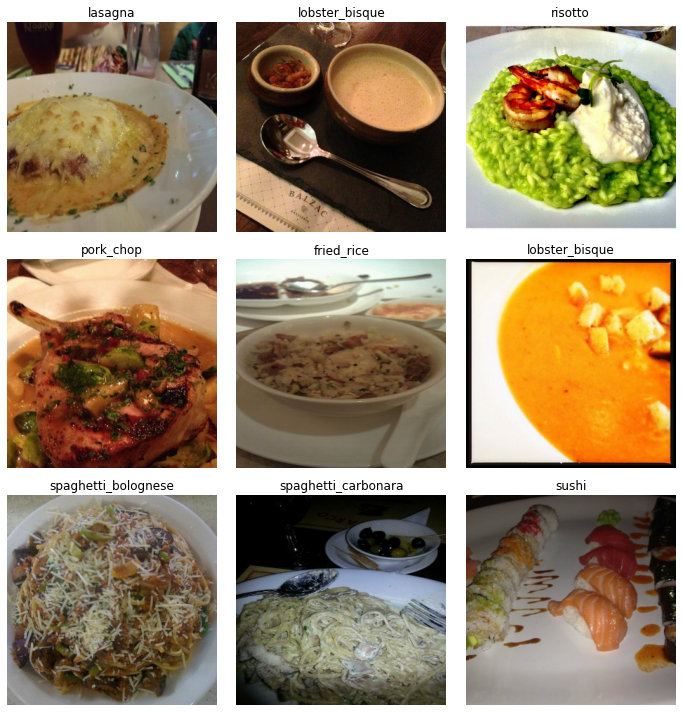

In [16]:
# code from https://www.tensorflow.org/tutorials/images/classification
plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[tf.argmax(labels[i], axis=0)])
    plt.axis("off")
    plt.tight_layout()

# Predicting on our Data Using Pre-Trained Model

49152/35363 [=========================================] - 0s 0us/step


[('n07579787', 'plate', 0.097408935),
 ('n03400231', 'frying_pan', 0.08795336),
 ('n07717410', 'acorn_squash', 0.046912346),
 ('n07871810', 'meat_loaf', 0.042550877),
 ('n07873807', 'pizza', 0.04112037)]

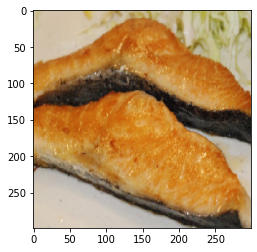

In [17]:
# code from https://neptune.ai/blog/transfer-learning-guide-examples-for-images-and-text-in-keras

# instantiating the Xception pre-trained weights model
model = Xception(weights='imagenet')
# our image path to one of our dataset's images
img_path_single = "/content/drive/My Drive/Capstone/food-11/images/dinner/grilled_salmon/7318.jpg"
# loading the image and preprocessing it for the model to predict it using the pre-trained weights
img = image.load_img(img_path_single, target_size=img_size_tup)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
preds = model.predict(x)
plt.imshow(img)
# decoding the results into a list of tuples (class, description, probability)
decode_predictions(preds, top=5)[0]

Our pre-trained model Xception (which was also trained on food images as well as other classes) is doing a pretty terrible job predicting our french fries. These pre-trained models will serve as the base for our model to try to get our predictions right.

# Modeling with Neural Nets & Pre-trained Weights

## Modeling with Xception Pretrained Model

In [18]:
# code from https://keras.io/api/optimizers/

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.7,
    decay_steps=100000,
    decay_rate=0.7)

In [19]:
# code help: https://keras.io/api/applications/
# code help: https://www.tensorflow.org/api_docs/python/tf/keras/applications/xception/Xception

# create the base pre-trained model
X_model = Xception(weights='imagenet', include_top=False)

for layer in X_model.layers:
    layer.trainable = False

# add a global spatial average pooling layer
x = X_model.output
x = GlobalAvgPool2D()(x)
# let's add a fully-connected layer
x = Dense(32, activation='relu')(x)
x = Dropout(0.5)(x)
# and a logistic layer 
predictions = Dense(n_classes, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=X_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional layers

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer=SGD(learning_rate=lr_schedule), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])
early_stop = EarlyStopping(mode='auto', patience=15)

# train the model on the new data for a few epochs
X_results = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=128, callbacks=early_stop, workers=4)

# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(X_model.layers):
   print(i, layer.name)


83697664/83683744 [==============================] - 1s 0us/step
Epoch 1/100
1/1 [==============================] - 5s 5s/step - loss: 3.1020 - accuracy: 0.0000e+00 - val_loss: 3.0946 - val_accuracy: 0.0625
Epoch 2/100
1/1 [==============================] - 0s 301ms/step - loss: 3.0329 - accuracy: 0.0625 - val_loss: 3.2674 - val_accuracy: 0.0625
Epoch 3/100
1/1 [==============================] - 0s 299ms/step - loss: 2.8250 - accuracy: 0.1250 - val_loss: 3.0781 - val_accuracy: 0.1250
Epoch 4/100
1/1 [==============================] - 0s 302ms/step - loss: 2.9280 - accuracy: 0.1562 - val_loss: 3.0544 - val_accuracy: 0.0625
Epoch 5/100
1/1 [==============================] - 0s 306ms/step - loss: 2.4339 - accuracy: 0.2500 - val_loss: 3.4795 - val_accuracy: 0.1250
Epoch 6/100
1/1 [==============================] - 0s 298ms/step - loss: 2.5703 - accuracy: 0.2812 - val_loss: 3.0773 - val_accuracy: 0.0312
Epoch 7/100
1/1 [==============================] - 0s 299ms/step - loss: 2.5886 - accura

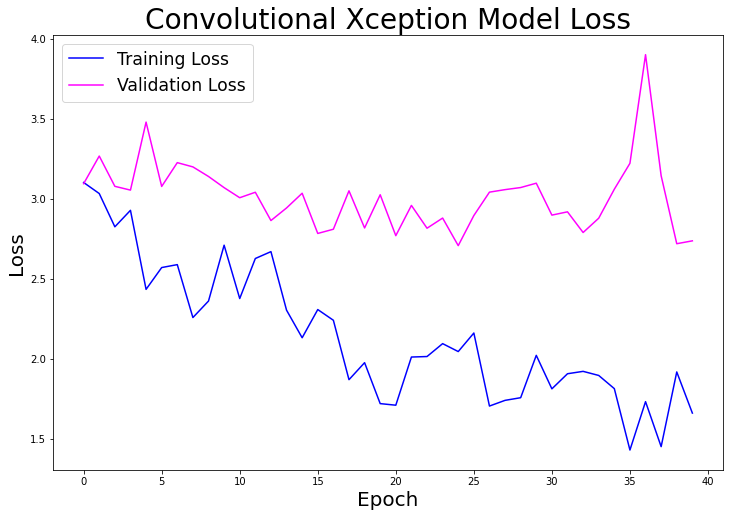

In [20]:
# plotting our accuracy for training and testing
plt.figure(figsize=(12,8))
plt.plot(X_results.history['loss'], label='Training Loss', color='blue')
plt.plot(X_results.history['val_loss'], label='Validation Loss', color='fuchsia')
plt.legend(fontsize='xx-large')
plt.title('Convolutional Xception Model Loss', size=28)
plt.xlabel('Epoch', size=20)
plt.ylabel('Loss', size=20)
plt.savefig('/content/drive/My Drive/Capstone/X_loss_apps.png', bbox_inches='tight');

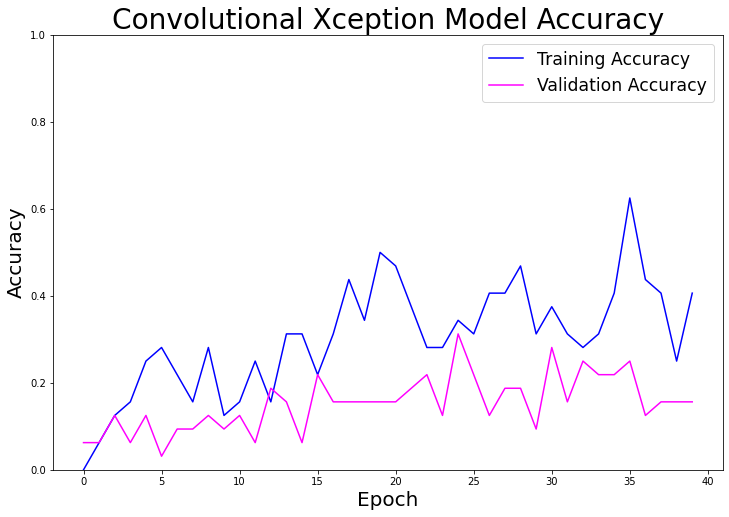

In [21]:
# plotting our accuracy for training and testing
plt.figure(figsize=(12,8))
plt.plot(X_results.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(X_results.history['val_accuracy'], label='Validation Accuracy', color='fuchsia')
plt.legend(fontsize='xx-large')
plt.title('Convolutional Xception Model Accuracy', size=28)
plt.ylim(0, 1.00)
plt.xlabel('Epoch', size=20)
plt.ylabel('Accuracy', size=20)
plt.savefig('/content/drive/My Drive/Capstone/X_accuracy_apps.png', bbox_inches='tight');

In [22]:
# evaluating on test data
X_score = model.evaluate(X_test, y_test, verbose=1)

X_labels = model.metrics_names

# printing Xception scores
print(f'Xception {X_labels[0]}  : {X_score[0]}')
print(f'Xception {X_labels[1]}   : {X_score[1]}')

1/1 [==============================] - 1s 1s/step - loss: 2.7372 - accuracy: 0.1562
Xception loss  : 2.7372422218322754
Xception accuracy   : 0.15625


** Interpretation **

The Xception pre-trained model isn't doing well on this subset, with 37.5% accuracy on testing data (90% on training).

In [23]:
# saving the model
from tensorflow.keras.models import load_model, clone_model
model.save("/content/drive/My Drive/Capstone/Xception_model_dinner.h5")
pickle.dump(model, open("/content/drive/My Drive/Capstone/Xception_model_dinner.p", 'wb'))

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


INFO:tensorflow:Assets written to: ram://d7fd186a-2798-4349-a36c-d2779886db32/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [24]:
## code from lesson 9.04
# making predictions on X_test
preds_1 = np.argmax(model.predict(X_test), axis = 1)

# saving predictions to dataframe & output to .csv
X_test_pred_df_1 = pd.DataFrame({
    'Label': preds_1,
    'ImageId': range(1,X_test.shape[0] + 1)
})
X_test_pred_df_1.to_csv('/content/drive/My Drive/Capstone/X_preds_dinner.csv', index=False)

# Testing Our Model on Random Images

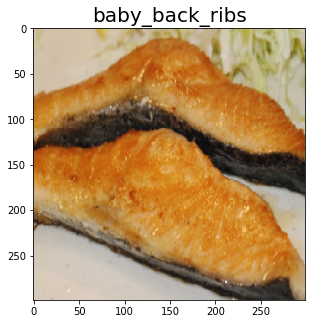

In [25]:
# visualizing one prediction
plt.figure(figsize=(5,5))
# loading the image and preprocessing it for the model to predict it using the pre-trained weights
img = image.load_img(img_path_single, target_size=img_size_tup)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

preds = model.predict(x)
plt.title(class_names[np.argmax(preds.astype(int))], size=20)
plt.imshow(img);


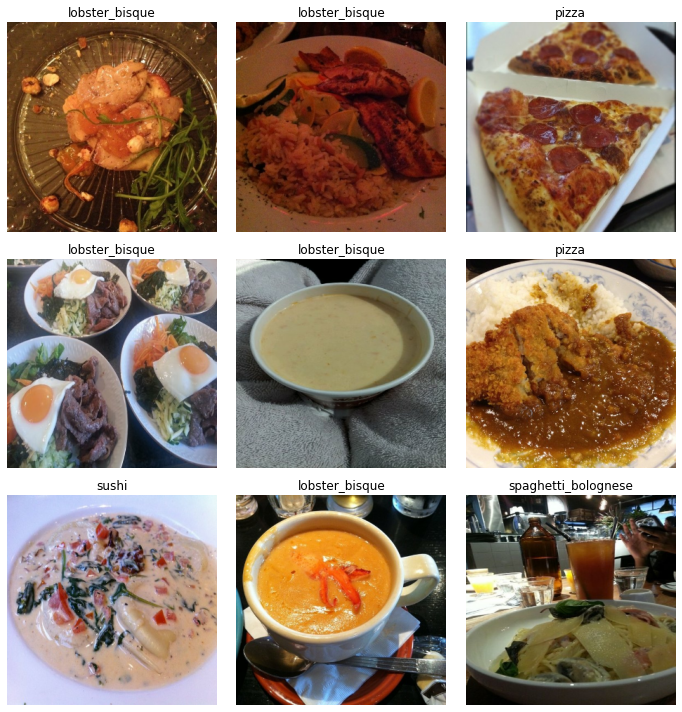

In [26]:
# visualizing images with model predictions
plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  # plt.imshow(X_test[i])
  result=(model.predict(X_test))
  plt.imshow(X_test[i])
  plt.title(class_names[np.argmax(result[i])])
  plt.axis("off")
  plt.tight_layout()

Our Xception model is extremely overfit and doesn't perform well on our test data. Below we will try using data augmentation to add more images for training and testing, which should help our model's loss and scores. Data augmentation is a method of creating new similar images from our existing image dataset in order to supplement our data when there isn't enough to get good model results from.

In [27]:
# https://github.com/hbhasin/Image-Recognition-with-Deep-Learning/blob/master/Image%20Classification%20with%20Transfer%20Learning.md



# data pre-processing for training
train_datagen =  ImageDataGenerator( 
    rescale = 1./255,
    rotation_range = 25,
    width_shift_range = 0.25,
    height_shift_range = 0.25,
    shear_range = 0.25,
    zoom_range = 0.25,
    brightness_range=[0.6,1.0],
    fill_mode = 'nearest',
    horizontal_flip = True,
    validation_split=0.2)

# data pre-processing for validation
validate_datagen =  ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 25,
    width_shift_range = 0.25,
    height_shift_range = 0.25,
    shear_range = 0.25,
    zoom_range = 0.25,
    brightness_range=[0.6,1.0],
    fill_mode = 'nearest',
    horizontal_flip = True,
    validation_split=0.2)


# generate and store training data
train_generator = train_datagen.flow_from_directory(
    img_path,
    class_mode = 'categorical',
    target_size = img_size_tup,
    batch_size = 32, 
    subset='training',
    )

# generate and store validation data
validate_generator = validate_datagen.flow_from_directory(
    img_path,
    class_mode = 'categorical',
    target_size = img_size_tup,
    batch_size = 32,
    subset='validation')

Found 17616 images belonging to 22 classes.
Found 4403 images belonging to 22 classes.


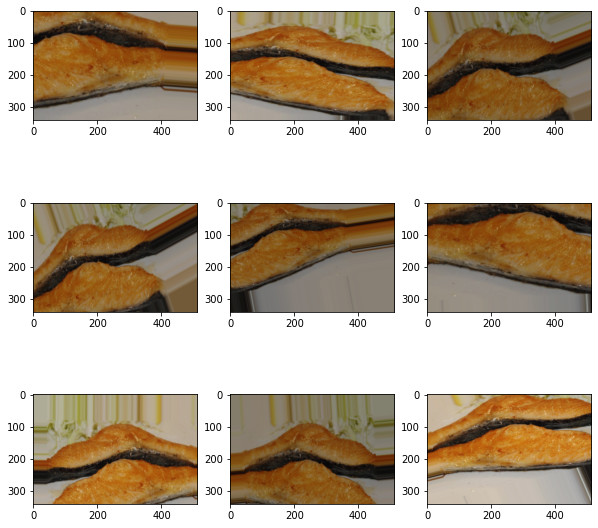

In [28]:
# code help from https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/
# visualizing our images with data augmentation implemented
plt.figure(figsize=(10, 10))
# load the image
img = load_img(img_path_single)
# convert to numpy array
data = img_to_array(img)
# expand dimension to one sample
samples = expand_dims(data, 0)

data_augmentation = train_datagen.flow(samples, batch_size=1)
# generate samples and plot
for i in range(9):
	# define subplot
	plt.subplot(330 + 1 + i)
	# generate batch of images
	batch = data_augmentation.next()
	# plot raw pixel data
	plt.imshow(batch[0])
# show the figure
plt.show()

In [29]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.7, 
    decay_steps=10000,
    decay_rate=0.7)

# create the base pre-trained model
X_model = Xception(weights='imagenet', include_top=False)


# add a global spatial average pooling layer
x = X_model.output
x = GlobalAvgPool2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
# and a logistic layer 
predictions = Dense(n_classes, activation='softmax')(x)

model = Model(inputs=X_model.input, outputs=predictions)

for layer in X_model.layers:
    layer.trainable = False

model.compile(optimizer=SGD(learning_rate=lr_schedule), 
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), 
              metrics=['accuracy'])
early_stop = EarlyStopping(mode='auto', patience=15)

# fit the model, log the results and the training time
now = datetime.datetime.now
t = now()
results_2 = model.fit(
    train_generator,
    epochs=100, 
    steps_per_epoch=140, 
    callbacks=early_stop, 
    workers=8,
    validation_data = validate_generator)
print('Training time: %s' % (now() - t))


Epoch 1/100


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


140/140 [==============================] - 277s 2s/step - loss: 2.5453 - accuracy: 0.2657 - val_loss: 2.0023 - val_accuracy: 0.4099
Epoch 2/100
140/140 [==============================] - 172s 1s/step - loss: 2.2331 - accuracy: 0.3313 - val_loss: 1.8517 - val_accuracy: 0.4429
Epoch 3/100
140/140 [==============================] - 156s 1s/step - loss: 2.1625 - accuracy: 0.3627 - val_loss: 1.9110 - val_accuracy: 0.4088
Epoch 4/100
140/140 [==============================] - 161s 1s/step - loss: 2.0888 - accuracy: 0.3886 - val_loss: 1.9419 - val_accuracy: 0.4090
Epoch 5/100
140/140 [==============================] - 135s 944ms/step - loss: 2.0337 - accuracy: 0.4017 - val_loss: 1.7466 - val_accuracy: 0.4549
Epoch 6/100
140/140 [==============================] - 136s 923ms/step - loss: 1.9704 - accuracy: 0.4317 - val_loss: 1.5891 - val_accuracy: 0.5301
Epoch 7/100
140/140 [==============================] - 132s 919ms/step - loss: 1.9548 - accuracy: 0.4205 - val_loss: 1.6586 - val_accuracy: 0.

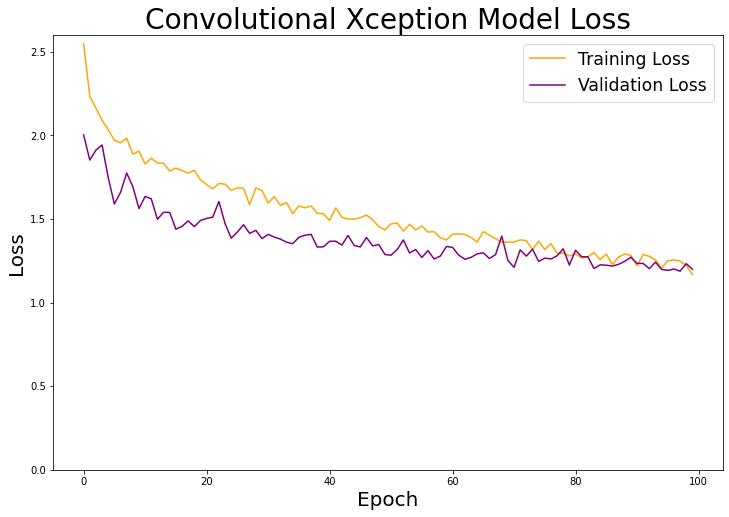

In [36]:
# plotting our accuracy for training and testing
plt.figure(figsize=(12,8))
plt.plot(results_2.history['loss'], label='Training Loss', color='orange')
plt.plot(results_2.history['val_loss'], label='Validation Loss', color='purple')
plt.legend(fontsize='xx-large')
plt.title('Convolutional Xception Model Loss', size=28)
plt.ylim(0,2.6)
plt.xlabel('Epoch', size=20)
plt.ylabel('Loss', size=20)
plt.savefig('X_loss_dinner_DA.png', bbox_inches='tight');

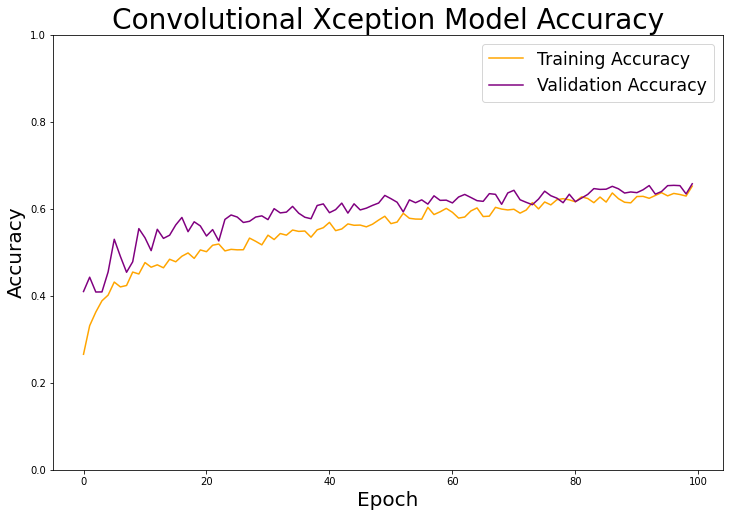

In [38]:
# plotting our accuracy for training and testing
plt.figure(figsize=(12,8))
plt.plot(results_2.history['accuracy'], label='Training Accuracy', color='orange')
plt.plot(results_2.history['val_accuracy'], label='Validation Accuracy', color='purple')
plt.legend(fontsize='xx-large')
plt.title('Convolutional Xception Model Accuracy', size=28)
plt.ylim(0,1.00)
plt.xlabel('Epoch', size=20)
plt.ylabel('Accuracy', size=20)
plt.savefig('X_accuracy_dinner_DA.png', bbox_inches='tight');

In [32]:
model.save("/content/drive/My Drive/Capstone/Xception_model_dinner_DA.h5")
pickle.dump(model, open("/content/drive/My Drive/Capstone/Xception_model_dinner_DA.p", 'wb'))

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


INFO:tensorflow:Assets written to: ram://2b474bd0-39ea-47d7-bb64-32a9654b6062/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [ ]:
# evaluating on test data
X_score_DA = model.evaluate(X_test, y_test, verbose=1)

X_labels_DA = model.metrics_names

# printing Xception scores
print(f'Xception {X_labels[0]}  : {X_score[0]}')
print(f'Xception {X_labels[1]}   : {X_score[1]}')
print(f'Xception_DA {X_labels_DA[0]}  : {X_score_DA[0]}')
print(f'Xception_DA {X_labels_DA[1]}   : {X_score_DA[1]}')

In [ ]:
# visualizing one prediction
plt.figure(figsize=(5,5))

# loading the image and preprocessing it for the model to predict it using the pre-trained weights
img = image.load_img(img_path_single, target_size=img_size_tup)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
# x = preprocess_input(x)
preds = model.predict(x)
plt.title(class_names[np.argmax(preds.astype(int))], size=20)
plt.imshow(img);

In [ ]:
# visualizing images with model predictions
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    # plt.imshow(X_test[i])
    result=(model.predict(X_test))
    plt.imshow(X_test[i])
    plt.title(class_names[np.argmax(result[i])])
    plt.axis("off")
    plt.tight_layout()

# Conclusions & Recommendations